In [25]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import tensorflow as tf

In [26]:
# on Google Colab, get the dataset from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# unzip the dataset for use
from zipfile import ZipFile
file_name = '/content/drive/MyDrive/Poison Plant Classifier/Dataset.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [28]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import splitfolders

splitfolders.ratio("Dataset", # The location of dataset
                   output="Training_Datasets", # The output location
                   seed=42, # The number of seed
                   ratio=(.8, .2), # The ratio of splited dataset
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Copying files: 10610 files [00:04, 2153.01 files/s]


In [30]:
train_dir = os.path.join('/content/Training_Datasets', 'train')
validation_dir = os.path.join('/content/Training_Datasets', 'val')

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            label_mode='int',
                                                            batch_size=64,
                                                            image_size=(224, 224))

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='int',
                                                                 batch_size=64,
                                                                 image_size=(224, 224))
                                                                 

Found 8486 files belonging to 4 classes.
Found 2124 files belonging to 4 classes.


In [31]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [32]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and eLU activation
x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001))(x)

# Add a dropout rate of 0.5
x = tf.keras.layers.Dropout(0.6)(x)

# Add a final softmax layer with 1 node for classification output
x = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [34]:
vgghist = model.fit(train_dataset, validation_data = validation_dataset, epochs = 15)

Epoch 1/15
133/133 [==============================] - 55s 397ms/step - loss: 4.4557 - accuracy: 0.5013 - val_loss: 1.1730 - val_accuracy: 0.6347
Epoch 2/15
133/133 [==============================] - 54s 399ms/step - loss: 1.1461 - accuracy: 0.6739 - val_loss: 1.1504 - val_accuracy: 0.6756
Epoch 3/15
133/133 [==============================] - 56s 412ms/step - loss: 0.8252 - accuracy: 0.7600 - val_loss: 1.1752 - val_accuracy: 0.7010
Epoch 4/15
133/133 [==============================] - 55s 404ms/step - loss: 0.6299 - accuracy: 0.8191 - val_loss: 1.2196 - val_accuracy: 0.7053
Epoch 5/15
133/133 [==============================] - 55s 407ms/step - loss: 0.4886 - accuracy: 0.8644 - val_loss: 1.3167 - val_accuracy: 0.7218
Epoch 6/15
133/133 [==============================] - 54s 401ms/step - loss: 0.3922 - accuracy: 0.8930 - val_loss: 1.4030 - val_accuracy: 0.7236
Epoch 7/15
133/133 [==============================] - 55s 406ms/step - loss: 0.3247 - accuracy: 0.9116 - val_loss: 1.5306 - val_ac

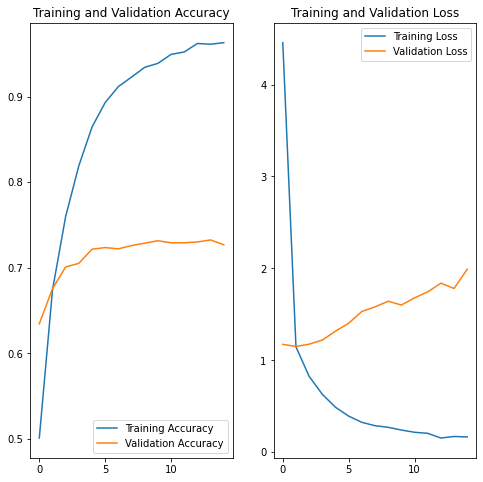

In [35]:
import matplotlib.pyplot as plt

acc = vgghist.history['accuracy']
val_acc = vgghist.history['val_accuracy']

loss = vgghist.history['loss']
val_loss = vgghist.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()